In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from typing import Literal
from util import df_to_nn_model_input, df_process_address_chars, calc_similarity_pair_fuzzy


2024-11-10 10:51:53.223283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 10:51:53.500422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 10:51:53.500538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 10:51:53.543494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 10:51:53.626056: I tensorflow/core/platform/cpu_feature_guar

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-11-10 11:03:30.859301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 11:03:30.859475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-10 11:03:30.859543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

## Full code

In [21]:
FUZZY_COLUMN = 'fuzzy_score'
NN_COLUMN = 'nn_score'

class AddressComparator:
    def __init__(
            self,
            output_path: str = None,
            file_path: str = None,
            nn_path: str = None,
            method: Literal['nn', 'combo'] = 'combo',  # Specify allowed values for 'method'
            save_scores: bool = False
    ):
        self.file_path = file_path
        self.output_path = output_path
        self.save_scores = save_scores
        self.address_column_names = ('address_1', 'address_2')
        self.result_column = 'prediction'
        self.df = self._upload_file()
        if nn_path:
            self.nn = tf.keras.models.load_model(nn_path)
            self.fuzzy_only = False
        else:
            self.fuzzy_only = True
        self.char_processed = False
        self.fuzzy_threshold_high = 0.85
        self.fuzzy_threshold_low = 0.25
        self.method = method
    
    def _check_columns(self, df):
        if self.address_column_names[0] not in df.columns or self.address_column_names[1] not in df.columns:
            raise ValueError(f"The DataFrame is missing the following required columns: {self.address_column_names}")
    
    def _upload_file(self, *args):    
        if len(args) == 1 and isinstance(args[0], pd.DataFrame):
            df = args[0]
            self._check_columns(df)
            self.df = df
        elif isinstance(self.file_path, str):
            df = pd.read_csv(self.file_path)
            self._check_columns(df)
            return df
        else:
            print('no data uploaded!')
    
    def calculate_fuzzy_scores(self):
        self.df[FUZZY_COLUMN] = self.df.apply(
            lambda row: calc_similarity_pair_fuzzy(row['address_1'], row['address_2']), axis=1)
    
    def prepare_data(self):
        self.df = df_process_address_chars(self.df)
    
    def set_same_flag(self):
        if self.method == 'combo':
            self.df[self.result_column] = np.nan
            self.df[self.result_column] = np.where(self.df[FUZZY_COLUMN] > self.fuzzy_threshold_high, 1, np.nan)
            self.df[self.result_column] = np.where(
                (self.df[FUZZY_COLUMN] < self.fuzzy_threshold_low) & (self.df[self.result_column].isnull()), 0, self.df[self.result_column]
            )
            if NN_COLUMN in self.df.columns:
                self.df[self.result_column] = self.df[self.result_column].fillna((self.df[NN_COLUMN] > 0.5).astype(int))
            else:
                self.df[self.result_column] = self.df[self.result_column].fillna(0)
                
        elif self.method == 'nn' and NN_COLUMN in self.df.columns:
            self.df[self.result_column] = (self.df[NN_COLUMN] > 0.5).astype(int)
        
    def run(self):
        if not self.char_processed:
            self.prepare_data()
            self.char_processed = True
        self.calculate_fuzzy_scores()
        
        if self.char_processed and not self.fuzzy_only:
            nn_data = df_to_nn_model_input(self.df)
            self.df[NN_COLUMN] = self.nn.predict(nn_data)
        
        self.set_same_flag()
        
        if self.output_path:
            if not self.save_scores:
                save_df = self.df[[*self.address_column_names, self.result_column]]
                save_df.to_csv(self.output_path)
            else:
                self.df.to_csv(self.output_path)

## Test pipeline

In [28]:
AC = AddressComparator(nn_path='tf_nn_similarity_model.keras', method='nn')
test_df = pd.read_csv('test_data.csv')

my_df = pd.DataFrame({"address_1":[
    "місто Київ, оболонський р-н, оболонський проспект 19, кв 122",
    "місто Київ, оболонський р-н, оболонський проспект 19, кв 122",
    "Луганськ, квартал Лєнінського комсомолу, буд 8а кв 101",
    "село Варені яйця курячого району, вулиця жовткова, буд 88к1"
],
    "address_2":[
        "місто Київ, святошинський район, вул вацлава гавела 2, кв 3",
        "місто Київ, оболонський р-н, оболонський проспект 12, кв 77",
        "м. Луганськ кв. лєнінського комсомолу, б 8-а квартира 101",
        "район курячій, с. Варені яйця , в. жовткова, будинок 88к1"
    ]})

AC._upload_file(my_df)
AC.run()

no data uploaded!
1/1 [==============================] - 1s 627ms/step


In [29]:
AC.df

,address_1,address_2,fuzzy_score,nn_score,prediction
0,"місто київ, оболонський р-н, оболонський просп...","місто київ, святошинський район, вул вацлава г...",0.56,0.028187,0
1,"місто київ, оболонський р-н, оболонський просп...","місто київ, оболонський р-н, оболонський просп...",0.95,0.015254,0
2,"луганськ, квартал лєнінського комсомолу, буд 8...","м. луганськ кв. лєнінського комсомолу, б 8-а к...",0.85,0.995464,1
3,"село варені яйця курячого району, вулиця жовтк...","район курячій, с. варені яйця , в. жовткова, б...",0.63,0.982835,1


## Check runtime

In [8]:
test_df_big = pd.concat([test_df for _ in range(1000)], ignore_index=True)

In [9]:
test_df_big.shape

(320000, 3)

In [12]:
import time

start_time_combo = time.time()
AC_combo = AddressComparator(nn_path='tf_nn_similarity_model.keras', method='combo')
AC_combo._upload_file(test_df_big)
AC_combo.run()
end_time_combo = time.time()
runtime = end_time_combo - start_time_combo
print(f"Runtime combo : {runtime:.2f} seconds")

start_time_nn = time.time()
AC_nn = AddressComparator(nn_path='tf_nn_similarity_model.keras', method='nn')
AC_nn._upload_file(test_df_big)
AC_nn.run()
end_time_nn = time.time()
runtime = end_time_nn - start_time_nn
print(f"Runtime nn : {runtime:.2f} seconds")

no data uploaded!
10000/10000 [==============================] - 62s 6ms/step
Runtime combo : 81.45 seconds
no data uploaded!
10000/10000 [==============================] - 61s 6ms/step
Runtime nn : 80.38 seconds


## fuzzy_score analytics 

no data uploaded!
10/10 [==============================] - 1s 8ms/step


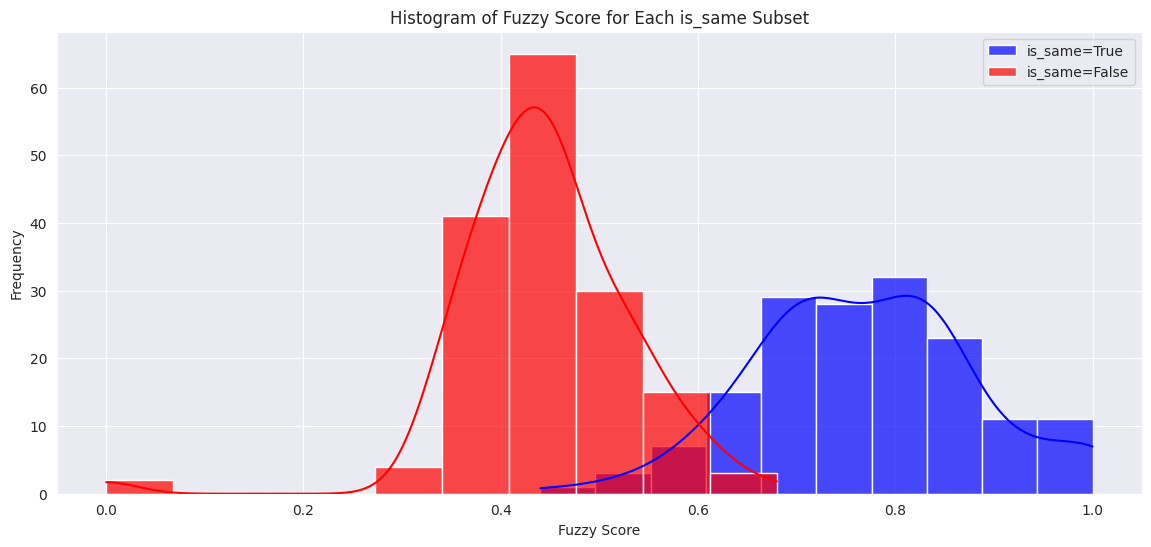

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

AC = AddressComparator(nn_path='tf_nn_similarity_model.keras', method='combo')
test_df = pd.read_csv('test_data.csv')
AC._upload_file(test_df)
AC.run()

df = AC.df
# Plot histograms for each subset of `is_same`
plt.figure(figsize=(14, 6))

# Plot for is_same == True
sns.histplot(df[df['is_same'] == True]['fuzzy_score'], bins=10, kde=True, color='blue', label='is_same=True', alpha=0.7)

# Plot for is_same == False
sns.histplot(df[df['is_same'] == False]['fuzzy_score'], bins=10, kde=True, color='red', label='is_same=False', alpha=0.7)

# Add labels and title
plt.xlabel('Fuzzy Score')
plt.ylabel('Frequency')
plt.title('Histogram of Fuzzy Score for Each is_same Subset')
plt.legend()

# Show the plot
plt.show()

In [25]:
df[df['is_same'] != df['prediction']]  ## WRONG PREDICTIONS

,address_1,address_2,is_same,fuzzy_score,nn_score,prediction
23,"донецька обл., м.словянськ, вул.василевського,...","чернівецька обл., місто чернівці вулиця універ...",False,0.53,0.639869,1.0
152,"київська обл., село погреби, вул.кірова, буд 2...","київська обл., броварський район, село погреби...",True,0.71,0.034065,0.0
154,"житомирьска обл., богунський р-н, м.житомир, в...","10020, вул. максютова, 18, кв.3, м.житомир, бо...",True,0.62,0.498143,0.0
174,"03148, м.київ, просп.курбаса леся, 9, кв.345","03148, місто київ, проспект курбаса леся, буди...",True,0.75,0.007580,0.0
179,"росйська федераця, москва, вул.новолісна, 17а,...","росйська федераця, москва, вулиця новолісна бу...",True,0.83,0.115050,0.0
262,"96300, автономна республіка крим, первомайськи...","96300, автономна республіка крим, первомайськи...",True,0.79,0.027115,0.0
299,"42081, сумська обл., роменський р-н, с.глинськ...","сумська обл., с.глинськ, вулиця адмірала кулик...",True,0.76,0.058005,0.0
312,луцьк,львів,False,0.40,0.977155,1.0
313,львів,луцьк,False,0.40,0.974106,1.0
314,донецьк,дніпро,False,0.33,0.983430,1.0


## Accuracy analytics

In [26]:
len(df[df['is_same'] == df['prediction']])/len(df)

0.96875

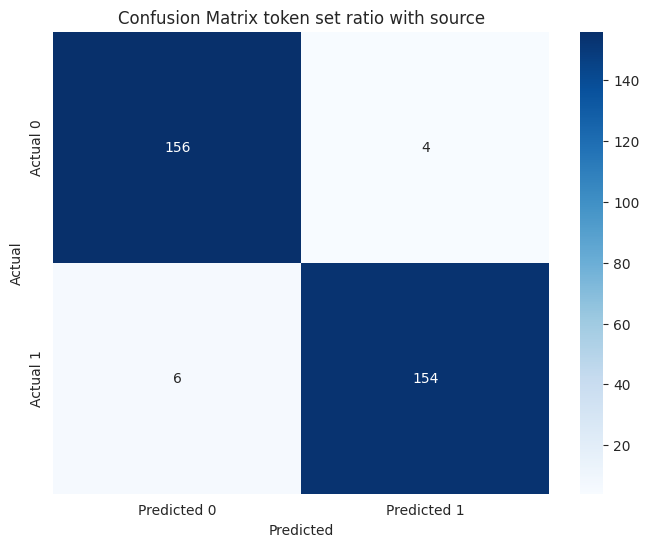

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(df['is_same'], df['prediction'])
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix token set ratio with source')
plt.show()